In [261]:
!pip install pykalman

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 447.7 kB/s eta 0:00:00 kB/s eta 0:00:01:01
  Preparing metadata (setup.py) ... done
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48442 sha256=05bb1e1589e3cab9d47b51e84ba8088fd2dc772135188ed1cf9de20ddea29b6a
  Stored in directory: /home/rass/.cache/pip/wheels/05/c8/d9/6f343bfea436aa40ad725f7815e3e735b5b42518fded200cd2
Successfully built pykalman


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib.pyplot import plot
import scienceplots
plt.style.use('science')

import numpy as np

import scipy
from scipy import signal
from scipy.signal import butter,filtfilt

import pywt

T = 1/1500            # Sample Period
f = 1500 # sample rate, Hz
cutoff = 0.2
nyq = 0.5 * f  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * f) # total number of samples
wavelet = pywt.ContinuousWavelet('cgau1')


In [2]:
ls

1_16:16_contact-slide-experiment.csv  18_2:7_experiment.csv
1_16:18_contact-slide-experiment.csv  21_20:23_experiment.csv
1_16:21_contact-slide-experiment.csv  4_12:35_contact-slide-experiment.csv
1_16:24_contact-slide-experiment.csv  4_12:37_contact-slide-experiment.csv
1_16:26_contact-slide-experiment.csv  4_12:38_contact-slide-experiment.csv
1_16:27_contact-slide-experiment.csv  4_12:40_contact-slide-experiment.csv
1_16:29_contact-slide-experiment.csv  4_12:42_contact-slide-experiment.csv
1_16:34_contact-slide-experiment.csv  4_12:43_contact-slide-experiment.csv
1_16:35_contact-slide-experiment.csv  4_12:44_contact-slide-experiment.csv
1_16:37_contact-slide-experiment.csv  4_12:45_contact-slide-experiment.csv
1_16:38_contact-slide-experiment.csv  4_12:46_contact-slide-experiment.csv
1_16:39_contact-slide-experiment.csv  4_12:47_contact-slide-experiment.csv
1_16:41_contact-slide-experiment.csv  4_12:48_contact-slide-experiment.csv
1_16:45_contact-slide-experiment.csv  4_12:49_contact

In [88]:
df = pd.read_csv('test_acc.csv', header = None)

In [89]:
df = df.dropna()
df

,0,1
0,-9708.0,0.0
1,-9708.0,272.0
2,-9783.0,272.0
3,-9783.0,250.0
4,-9848.0,250.0
...,...,...
43363,-8928.0,-1503.0
43364,-8888.0,-1503.0
43365,-8888.0,-1375.0
43366,-8888.0,-1375.0


In [90]:
l = list(range(len(df[0])))

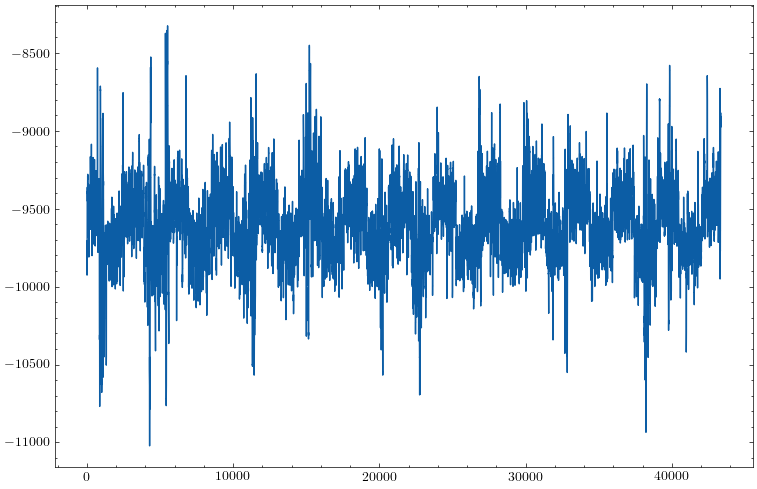

In [91]:
plt.figure(figsize=(9,6))
plt.plot(l,df[0])

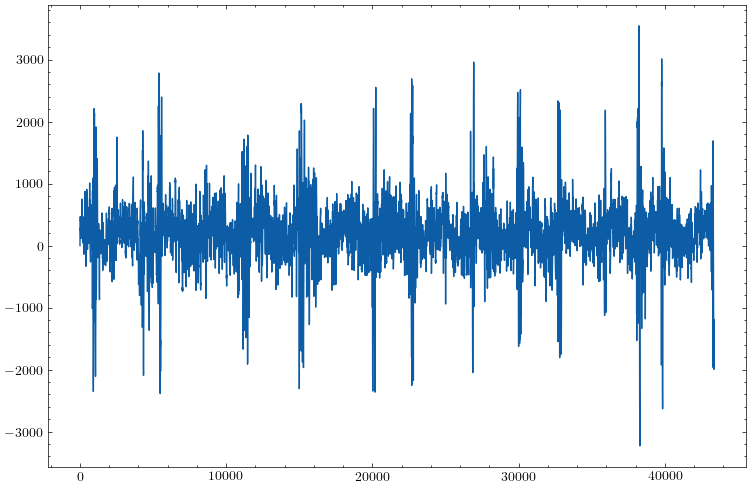

In [92]:
plt.figure(figsize=(9,6))
plt.plot(l,df[1])

In [8]:
def import_data(filename):
    df= pd.read_csv(filename, header = None)
    df.rename(columns={0: 'time_ros', 1: 'time',  2:'witt', 3:'hall1', 4:'hall2',5:'accelX',6:'accelY'}, inplace=True)
    df['witt'] = abs(df['witt'])
    df['accelX'] = df['accelX']-df['accelX'].mean()
    df['accelY'] = df['accelY']-df['accelY'].mean()
    df = df.drop(df[df.time <= 1000].index)
    print(df)
    return df

In [5]:
def plots(df):
    hall1 = abs(df['hall1'])
    hall2 = abs(df['hall2'])
    witt= abs(df['witt'])
    accelX = df['accelX']
    accelY = df['accelY']
    time = list(range(0,len(df['time'])))
    
    figure, axis = plt.subplots(2,2, figsize=(9, 9))
    
    axis[0][0].plot(time,witt)
    axis[0][0].set_title("Time vs Wittenstein")
    axis[0][0].set_xlabel('Time', fontsize=10)
    axis[0][0].set_ylabel('Wittenstein', fontsize=10)
    
    axis[0][1].plot(time,hall1, label = 'Red Hall')
    axis[0][1].legend(loc='upper left')

    axis[0][1].plot(time,hall2, label = 'Blue Hall')
    axis[0][1].legend(loc='upper left')

    axis[0][1].set_title("Time vs Hall Effects")
    axis[0][1].set_xlabel('Time', fontsize=10)
    axis[0][1].set_ylabel('Hall Effects', fontsize=10)
    
    axis[1][0].plot(time,accelX)
    axis[1][0].set_title("Time vs Accel X")
    axis[1][0].set_xlabel('Time', fontsize=10)
    axis[1][0].set_ylabel('Accel X', fontsize=10)
     
    axis[1][1].plot(time,accelY)
    axis[1][1].set_title("Time vs Accel Y")
    axis[1][1].set_xlabel('Time', fontsize=10)
    axis[1][1].set_ylabel('Accel Y', fontsize=10)

In [13]:
def wavelet_denoise(data, wavelet, noise_sigma):
    '''Filter accelerometer data using wavelet denoising

    Modification of F. Blanco-Silva's code at: https://goo.gl/gOQwy5
    '''
    import numpy
    data = np.array(data)
#     wavelet = pywt.ContiWavelet(wavelet)
    avelet = pywt.Wavelet(wavelet)
    levels  = min(1, (numpy.floor(numpy.log2(data.shape[0]))).astype(int))

    # Francisco's code used wavedec2 for image data
    wavelet_coeffs = pywt.wavedec(data, wavelet, level=levels)
    threshold = noise_sigma*numpy.sqrt(2*numpy.log2(data.size))

    new_wavelet_coeffs = map(lambda x: pywt.threshold(x, threshold, mode='soft'),
                             wavelet_coeffs)

    return pywt.waverec(list(new_wavelet_coeffs), wavelet)

def hall_filter(data, cutoff, fs, order):
    hall1 = data['hall1']
    hall2 = data['hall2']
    L = [hall1,hall2]
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    flTrs = [0]*2
    sg_Filter = [0]*2
    for i,v in enumerate(L):
        flTrs[i] = filtfilt(b, a, v)
        sg_Filter[i] = signal.savgol_filter(flTrs[i],
                               550, # window size used for filtering
                               2), # order of fitted polynomial
    return sg_Filter
def acc_filter(data, cutoff, fs, order):
    accelX = data['accelX']
    accelY = data['accelY']
    L = [accelX,accelY]
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    flTrs = [0]*2
    sg_Filter = [0]*2
    for i,v in enumerate(L):
        flTrs[i] = filtfilt(b, a, v)
        sg_Filter[i] = signal.savgol_filter(flTrs[i],
                               550, # window size used for filtering
                               2), # order of fitted polynomial
    return sg_Filter

In [5]:
ls

18_2:15_experiment.csv  18_2:7_experiment.csv    test_acc.csv
18_2:17_experiment.csv  21_20:23_experiment.csv  Untitled.ipynb


In [9]:
df = import_data('21_20:23_experiment.csv')

           time_ros   time      witt     hall1     hall2    accelX    accelY
1001   1.679409e+09   1001  0.398665  0.020019  0.160004 -0.000198  0.004494
1002   1.679409e+09   1002  0.396280 -0.000000  0.139999 -0.000228  0.002846
1003   1.679409e+09   1003  0.400481  0.020019  0.119995  0.000260  0.004769
1004   1.679409e+09   1004  0.380588  0.200012  0.160004 -0.002456  0.003426
1005   1.679409e+09   1005  0.405804  0.200012  0.160004 -0.003158  0.002968
...             ...    ...       ...       ...       ...       ...       ...
69995  1.679409e+09  19995  7.561460  0.179993  0.179993  0.000901  0.000283
69996  1.679409e+09  19996  7.585130  0.260010  0.160004  0.000443 -0.000083
69997  1.679409e+09  19997  7.508480  0.359985  0.139999  0.000351  0.001473
69998  1.679409e+09  19998  7.493440  0.320007  0.220001  0.001786  0.003792
69999  1.679409e+09  19999  7.550320  0.299988  0.220001  0.001664  0.002511

[67998 rows x 7 columns]


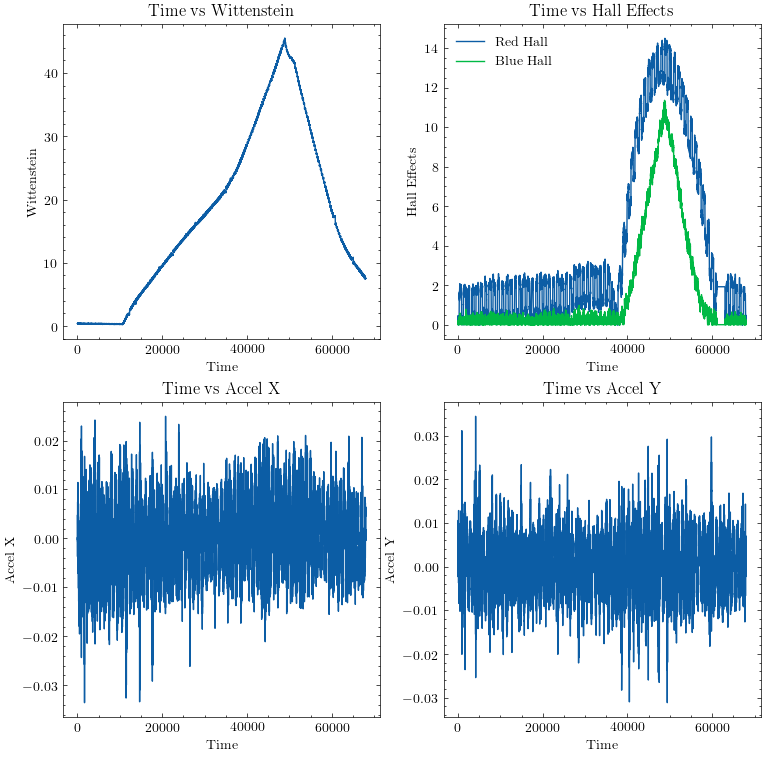

In [10]:
plots(df)

In [14]:
# filtered_hall = hall_filter(df, cutoff, f, order)
filtered_acc = acc_filter(df, 0.5, 1500, 2)

# filtered_acc = wavelet_denoise(df, 'haar', 15)

In [16]:
# df['hall1'] = filtered_hall[0][0]
# df['hall2'] = filtered_hall[1][0]
df['accelX'] = filtered_acc[0][0]
df['accelY'] = filtered_acc[1][0]

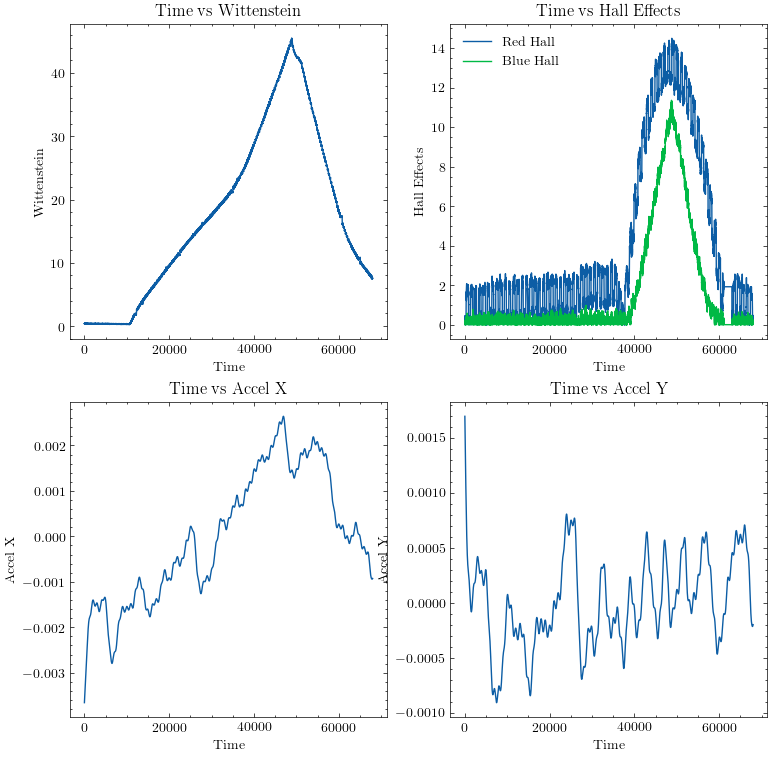

In [17]:
plots(df)

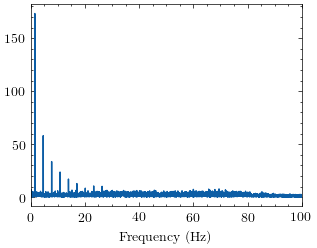

In [46]:
transformed_y = np.fft.fft( np.array(df['accelY']))
sample_rate = 1550
# Take the absolute value of the complex numbers for magnitude spectrum
freqs_magnitude = np.abs(transformed_y)

# Create frequency x-axis that will span up to sample_rate
freq_axis = np.linspace(0, sample_rate, len(df['time']))
# Plot frequency domainScreenshot from 2023-03-22 01-48-15
plt.plot(freq_axis, freqs_magnitude)
plt.xlabel("Frequency (Hz)")
plt.xlim(0, 100)
plt.show()

In [45]:
def median_filter(data, f_size):
    lgth, num_signal=data.shape
    f_data=np.zeros([lgth, num_signal])
    for i in range(num_signal):
        f_data[:,i]=signal.medfilt(data[:,i], f_size)
    return f_data

In [47]:
data = median_filter(df['accelY'], 150)

ValueError: not enough values to unpack (expected 2, got 1)

In [48]:
df['accelY'].shape

(67998,)

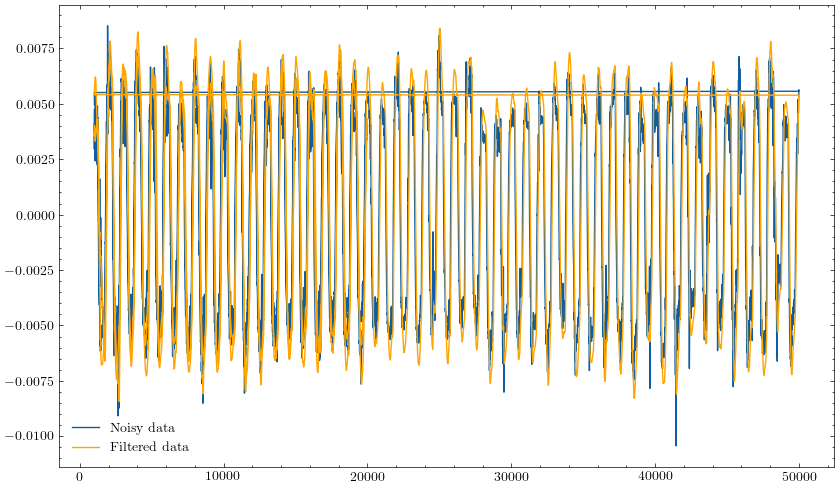

In [27]:
# Define state transition matrix
dt = 1/1500  # 100 Hz sampling rate for example
A = np.array([[1, dt], [0, 1]])

# Define measurement matrix
C = np.array([[1, 0]])

# Define process noise covariance matrix
Q = np.array([[1e-5, 0], [0, 1e-3]])

# Define measurement noise covariance matrix
R = np.array([[1e-1]])

# Initialize state estimate and error covariance matrix
x = np.array([0, 0])
P = np.diag([1, 1])

# Generate noisy data
data = np.array(df['accelY'])
t = np.array(df['time'])
# Initialize filtered data and filtered error covariance matrix
filtered_data = np.zeros(data.shape)
filtered_P = np.zeros(P.shape)

# Iterate over each measurement
for i in range(data.shape[0]):
    # Predict state estimate and error covariance matrix
    x_pred = A.dot(x)
    P_pred = A.dot(P).dot(A.T) + Q
    
    # Calculate Kalman gain
    K = P_pred.dot(C.T).dot(np.linalg.inv(C.dot(P_pred).dot(C.T) + R))
    
    # Update state estimate and error covariance matrix
    x = x_pred + K.dot(data[i] - C.dot(x_pred))
    P = (np.eye(2) - K.dot(C)).dot(P_pred)
    
    # Store filtered data and filtered error covariance matrix
    filtered_data[i] = x[0]
#     print(filtered_P[i])
#     filtered_P[i] = P[0, 0]

# Plot filtered data
plt.figure(figsize = (10,6))
plt.plot(t, data, label='Noisy data')
plt.plot(t, filtered_data, color = 'orange', label='Filtered data')
plt.legend()
plt.show()


In [22]:
df['accelY'] = filtered_data

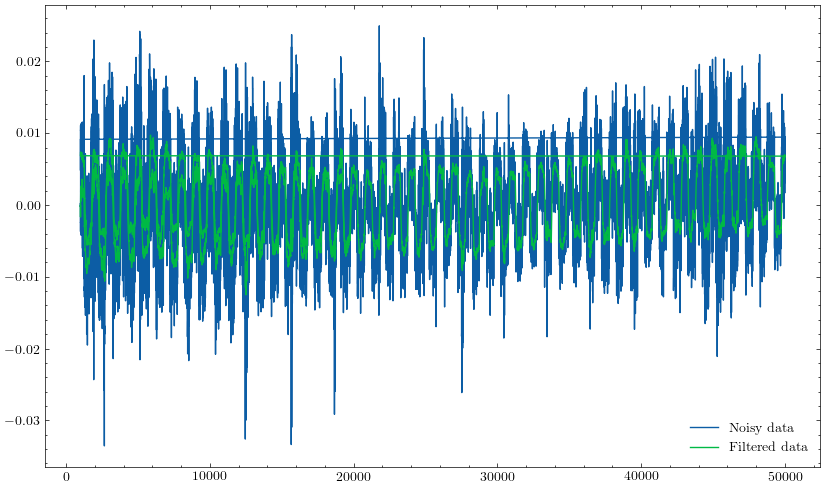

In [23]:
dt = 1/1500  # 100 Hz sampling rate for example
A = np.array([[1, dt], [0, 1]])

# Define measurement matrix
C = np.array([[1, 0]])

# Define process noise covariance matrix
Q = np.array([[1e-5, 0], [0, 1e-3]])

# Define measurement noise covariance matrix
R = np.array([[1e-1]])

# Initialize state estimate and error covariance matrix
x = np.array([0, 0])
P = np.diag([1, 1])

# Generate noisy data
data = np.array(df['accelX'])
t = np.array(df['time'])
# Initialize filtered data and filtered error covariance matrix
filtered_data = np.zeros(data.shape)
filtered_P = np.zeros(P.shape)

# Iterate over each measurement
for i in range(data.shape[0]):
    # Predict state estimate and error covariance matrix
    x_pred = A.dot(x)
    P_pred = A.dot(P).dot(A.T) + Q
    
    # Calculate Kalman gain
    K = P_pred.dot(C.T).dot(np.linalg.inv(C.dot(P_pred).dot(C.T) + R))
    
    # Update state estimate and error covariance matrix
    x = x_pred + K.dot(data[i] - C.dot(x_pred))
    P = (np.eye(2) - K.dot(C)).dot(P_pred)
    
    # Store filtered data and filtered error covariance matrix
    filtered_data[i] = x[0]
#     print(filtered_P[i])
#     filtered_P[i] = P[0, 0]

# Plot filtered data
plt.figure(figsize = (10,6))
plt.plot(t, data, label='Noisy data')
plt.plot(t, filtered_data, label='Filtered data')
plt.legend()
plt.show()


In [24]:
df['accelX'] = filtered_data

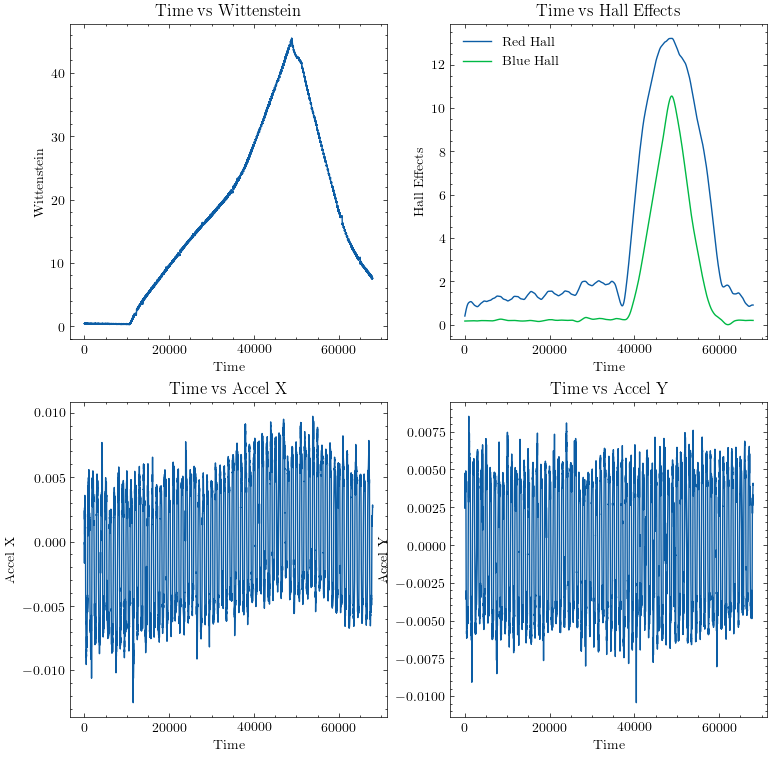

In [25]:
plots(df)